In [9]:
import numpy as np 
import MDAnalysis as md
import matplotlib.pyplot as plt
from numba import jit

Functions

In [10]:
def centeroidpython(data):
    """Returns the centroid of a set of points"""
    x, y, z = zip(*data)
    l = len(x)
    return sum(x) / l, sum(y) / l, sum(z) / l

def construct_covariance_matrix(pos, cen):
    """Constructs and returns the covariance matrix of points relative to an input centroid"""
    #Construc the covariance matrix from the centroid
    npoints = pos.shape[0]
    xx = 0
    xy = 0
    xz = 0
    yy = 0
    yz = 0
    zz = 0
    for p in pos:
        r = p - cen
        xx += r[0]*r[0]
        xy += r[0]*r[1]
        xz += r[0]*r[2]
        yy += r[1]*r[1]
        yz += r[1]*r[2]
        zz += r[2]*r[2]

    xx /= npoints
    xy /= npoints
    xz /= npoints
    yy /= npoints
    yz /= npoints
    zz /= npoints

    cov = np.array([ [xx, xy, xz], [xy, yy, yz], [xz, yz, zz] ])
    return cov


In [11]:
@jit
def gyration_tensor(pos):
    """Computes the gyration tensor from the postions
    afterwards diagonalizes the 3x3 matrix and obtain the eigenvalues and eigenvectors
    the two largeste eigenvalues (x and y) are then used for
    calculating the acylindricity"""
    npoints = pos.shape[0]
    xx = 0
    xy = 0
    xz = 0
    yx = 0
    yy = 0
    yz = 0
    zx = 0
    zy = 0
    zz = 0
    for idx, p in enumerate(pos):
        for indx, pp in enumerate(pos):
            xx += (p[0]-pp[0])**2
            xy += (p[0]-pp[0])*(p[0]-pp[1])
            xz += (p[0]-pp[0])*(p[2]-pp[2])
            yx += (p[1]-pp[1])*(p[0]-pp[0])
            yy += (p[1]-pp[1])**2
            yz += (p[1]-pp[1])*(p[2]-pp[2])
            zx += (p[2]-pp[2])*(p[0]-pp[0])
            zy += (p[2]-pp[2])*(p[1]-pp[1])
            zz += (p[2]-pp[2])**2

    xx *= (1/(2*(npoints**2)))
    xy *= (1/(2*(npoints**2)))
    xz *= (1/(2*(npoints**2)))
    yx *= (1/(2*(npoints**2)))
    yy *= (1/(2*(npoints**2)))
    yz *= (1/(2*(npoints**2)))
    zx *= (1/(2*(npoints**2)))
    zy *= (1/(2*(npoints**2)))
    zz *= (1/(2*(npoints**2)))

    cov = np.array([ [xx, xy, xz], [yx, yy, yz], [zx, zy, zz] ])
    
    eigenValues, eigenVectors = np.linalg.eigh(cov)
    
    eig_val_squared = eigenValues**2
    eig_val_idx = eig_val_squared.argsort()[::-1]
    eig_val_sorted  = eig_val_squared[eig_val_idx]
    p1, p2, p3 = eig_val_sorted[:3]
    
    #c = p2 - p1 #This is what it says in wikipedia. It provides negative results
    c = p1 - p2 #This is what they do in Kresten's paper
    
    return c

In [12]:
def func_eigval (u):
    coor = u.select_atoms('name BB').positions
    centroid = centeroidpython(coor)    
    C = construct_covariance_matrix(coor, centroid)

    eigenValues, eigenVectors = np.linalg.eigh(C)

    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    
    a,b = np.real(eigenValues[:2])    
    e = b / a
    
    return e

In [13]:
def func_run_eig (u, stride=1000):
    C = []
    for ts in u.trajectory[::stride]:
        c = func_eigval(u)
        C.append(c)
    return C

In [14]:
def func_run_gyration (u, stride=1000):
    E = []
    for ts in u.trajectory[::stride]:
        coor = u.select_atoms('name BB').positions
        E.append(gyration_tensor(coor))
    return E

Systems 

In [15]:
systems_M2 = ['1D1_69','1E3D1_134','2N2_302','NW9_58','NW11_73','NW13_151']
systems_M3 = ['1D1_69','1E3D1_134','2N2_302','NW9_57','NW11_72','NW13_150']

Estimating the shape by calculating the acylindricity from the gyration tensor
of the postions of the BackBone beads

In [16]:
M2_dataC = []
#M3_dataC = []
for i in range(6):
    loc_m2 = []
    #loc_m3 = []
    for r in range(1,4):
        C2 = []
        #C3 = []
        gro_m2 = 'ANALYSIS_Build_Martini2/GRO/{0:s}_v{1:d}_nowat.gro'.format(systems_M2[i], r)
        #gro_m3 = 'ANALYSIS_Build_Martini3/GRO/{0:s}_v{1:d}_nowat.gro'.format(systems_M3[i], r)
        xtc_m2 = 'ANALYSIS_Build_Martini2/XTC/{0:s}_v{1:d}_nowat_fit.xtc'.format(systems_M2[i], r)
        #xtc_m3 = 'ANALYSIS_Build_Martini3/XTC/{0:s}_v{1:d}_nowat_fit.xtc'.format(systems_M3[i], r)
                
        u2 = md.Universe(gro_m2, xtc_m2)
        #u3 = md.Universe(gro_m3, xtc_m3)
        
        C2 = func_run_gyration(u2, stride=1000)
        #C3 = func_run_gyration(u3, stride=1000)
        loc_m2.append(C2)
        #loc_m3.append(C3)
        
        np.save('ANALYSIS_Build_Martini2/M2_Gyration_tensor_data_{0:s}_v{1:d}.npy'.format(systems_M2[i], r), np.array(C2))
        #np.save('ANALYSIS_Build_Martini3/M3_Gyration_tensor_data_{0:s}_v{1:d}.npy'.format(systems_M3[i], r), np.array(C3))
        print ('Systems {0:s}_v{1:d}_nowat_fit.xtc done!'.format(systems_M3[i], r))
    M2_dataC.append(loc_m2)
    #M3_dataC.append(loc_m3)

Systems 1D1_69_v1_nowat_fit.xtc done!


/home/au447022/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:72: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/au447022/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:72: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


Systems 1D1_69_v2_nowat_fit.xtc done!
Systems 1D1_69_v3_nowat_fit.xtc done!
Systems 1E3D1_134_v1_nowat_fit.xtc done!
Systems 1E3D1_134_v2_nowat_fit.xtc done!
Systems 1E3D1_134_v3_nowat_fit.xtc done!
Systems 2N2_302_v1_nowat_fit.xtc done!
Systems 2N2_302_v2_nowat_fit.xtc done!
Systems 2N2_302_v3_nowat_fit.xtc done!
Systems NW9_57_v1_nowat_fit.xtc done!
Systems NW9_57_v2_nowat_fit.xtc done!
Systems NW9_57_v3_nowat_fit.xtc done!
Systems NW11_72_v1_nowat_fit.xtc done!
Systems NW11_72_v2_nowat_fit.xtc done!
Systems NW11_72_v3_nowat_fit.xtc done!
Systems NW13_150_v1_nowat_fit.xtc done!
Systems NW13_150_v2_nowat_fit.xtc done!
Systems NW13_150_v3_nowat_fit.xtc done!


In [17]:
M2_dataC[0][0]

[1344585.3898865364,
 1532956.1194408732,
 809215.1492590739,
 788306.4367628789,
 692305.9966218851,
 833048.9926680062,
 755953.4160104458,
 769702.614798269,
 498466.09665285086,
 270818.94881936954,
 188760.05923616828,
 253117.06782475894,
 254219.18882557738,
 410253.2400312177,
 319827.9064347978,
 238818.18734799803,
 184676.89276550943,
 493981.3609082982,
 306247.2140171265,
 164472.92964121944,
 178152.4689715996,
 237678.5023294806,
 622372.1427555201,
 76784.13239638228,
 319395.03261161945,
 685942.005066622,
 647036.6280241997,
 278491.2970041289,
 281862.4681329087,
 231804.27920441912,
 411023.2308005531,
 288231.67064927926,
 423100.5305549499,
 434426.7674138219,
 273438.58477284526,
 631397.3145504128,
 725466.6616823302,
 317033.32853292406,
 322725.4002249751,
 501276.00256325176,
 212881.18829502235,
 436625.64480824256,
 152050.01520380634,
 349313.28667558264,
 360792.82640923397,
 420340.3986464186,
 449616.2126710849,
 434701.80750941974,
 79554.03519094619,


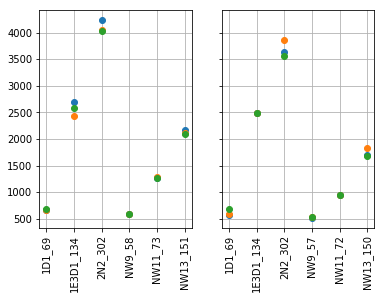

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)

ax[0].plot(np.sqrt([[np.average(i) for i in j ] for j in M2_dataC]), 'o')
ax[1].plot(np.sqrt([[np.average(i) for i in j ] for j in M3_dataC]), 'o')

#ax[0].plot(([[np.average(i) for i in j ] for j in M2_dataC]), 'o')
#ax[1].plot(([[np.average(i) for i in j ] for j in M3_dataC]), 'o')

ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels(systems_M2, rotation='vertical')

ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels(systems_M3, rotation='vertical')

ax[0].grid()
ax[1].grid()

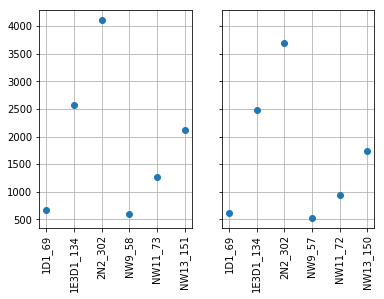

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)

ax[0].plot(np.sqrt(np.average([[np.average(i) for i in j ] for j in M2_dataC], axis=1)), 'o')
ax[1].plot(np.sqrt(np.average([[np.average(i) for i in j ] for j in M3_dataC], axis=1)), 'o')

ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels(systems_M2, rotation='vertical')

ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels(systems_M3, rotation='vertical')

ax[0].grid()
ax[1].grid()

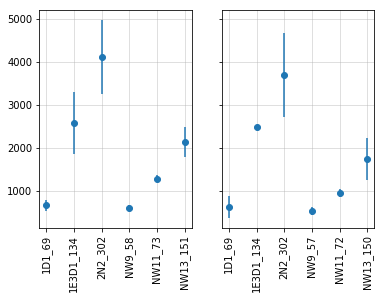

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)

x = [0,1,2,3,4,5]

ax[0].errorbar(x, np.sqrt(np.average([[np.average(i) for i in j ] for j in M2_dataC], axis=1)),
              yerr=np.sqrt(np.std([[np.average(i) for i in j ] for j in M2_dataC], axis=1)), fmt='o')
ax[1].errorbar(x, np.sqrt(np.average([[np.average(i) for i in j ] for j in M3_dataC], axis=1)),
              yerr=np.sqrt(np.std([[np.average(i) for i in j ] for j in M3_dataC], axis=1)), fmt='o')

ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels(systems_M2, rotation='vertical')

ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels(systems_M3, rotation='vertical')

ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)

Estimating the shape by simply dividing the two largest egenvalues from the covariance matrix constructed 
from the points of the BackBone beads

In [12]:
M2_data = []
M3_data = []
for i in range(6):
    loc_m2 = []
    loc_m3 = []
    for r in range(1,4):
        C2 = []
        C3 = []
        gro_m2 = 'ANALYSIS_Build_Martini2/GRO/{0:s}_v{1:d}_nowat.gro'.format(systems_M2[i], r)
        gro_m3 = 'ANALYSIS_Build_Martini3/GRO/{0:s}_v{1:d}_nowat.gro'.format(systems_M3[i], r)
        xtc_m2 = 'ANALYSIS_Build_Martini2/XTC/{0:s}_v{1:d}_nowat_fit.xtc'.format(systems_M2[i], r)
        xtc_m3 = 'ANALYSIS_Build_Martini3/XTC/{0:s}_v{1:d}_nowat_fit.xtc'.format(systems_M3[i], r)
                
        u2 = md.Universe(gro_m2, xtc_m2)
        u3 = md.Universe(gro_m3, xtc_m3)
        
        C2 = func_run_eig(u2, stride=100)
        C3 = func_run_eig(u3, stride=100)
        loc_m2.append(C2)
        loc_m3.append(C3)
        
        np.save('ANALYSIS_Build_Martini2/M2_shape_data_{0:s}_v{1:d}.npy'.format(systems_M2[i], r), np.array(C2))
        np.save('ANALYSIS_Build_Martini3/M3_shape_data_{0:s}_v{1:d}.npy'.format(systems_M3[i], r), np.array(C3))
        print ('Systems {0:s}_v{1:d}_nowat_fit.xtc done!'.format(systems_M3[i], r))
    M2_data.append(loc_m2)
    M3_data.append(loc_m3)

Systems 1D1_69_v1_nowat_fit.xtc done!
Systems 1D1_69_v2_nowat_fit.xtc done!
Systems 1D1_69_v3_nowat_fit.xtc done!
Systems 1E3D1_134_v1_nowat_fit.xtc done!
Systems 1E3D1_134_v2_nowat_fit.xtc done!
Systems 1E3D1_134_v3_nowat_fit.xtc done!
Systems 2N2_302_v1_nowat_fit.xtc done!
Systems 2N2_302_v2_nowat_fit.xtc done!
Systems 2N2_302_v3_nowat_fit.xtc done!
Systems NW9_57_v1_nowat_fit.xtc done!
Systems NW9_57_v2_nowat_fit.xtc done!
Systems NW9_57_v3_nowat_fit.xtc done!
Systems NW11_72_v1_nowat_fit.xtc done!
Systems NW11_72_v2_nowat_fit.xtc done!
Systems NW11_72_v3_nowat_fit.xtc done!
Systems NW13_150_v1_nowat_fit.xtc done!
Systems NW13_150_v2_nowat_fit.xtc done!
Systems NW13_150_v3_nowat_fit.xtc done!


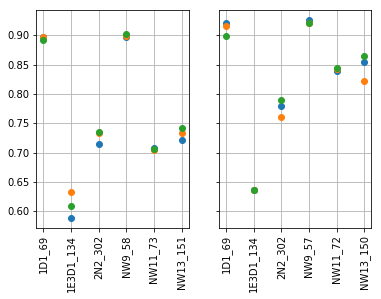

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)

ax[0].plot(np.sqrt([[np.average(i) for i in j ] for j in M2_data]), 'o')
ax[1].plot(np.sqrt([[np.average(i) for i in j ] for j in M3_data]), 'o')

ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels(systems_M2, rotation='vertical')

ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels(systems_M3, rotation='vertical')

ax[0].grid()
ax[1].grid()

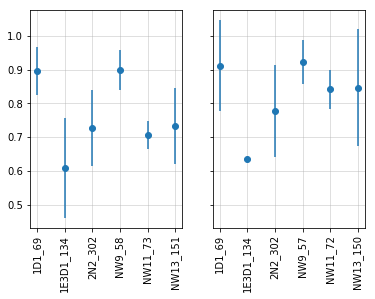

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)

x = [0,1,2,3,4,5]

ax[0].errorbar(x, np.sqrt(np.average([[np.average(i) for i in j ] for j in M2_data], axis=1)),
              yerr=np.sqrt(np.std([[np.average(i) for i in j ] for j in M2_data], axis=1)), fmt='o')
ax[1].errorbar(x, np.sqrt(np.average([[np.average(i) for i in j ] for j in M3_data], axis=1)),
              yerr=np.sqrt(np.std([[np.average(i) for i in j ] for j in M3_data], axis=1)), fmt='o')

ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels(systems_M2, rotation='vertical')

ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels(systems_M3, rotation='vertical')

ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)